In [13]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load the cleaned dataset
df = pd.read_csv('cleaned_dataset.csv')

# Function to evaluate KNN Imputer using MSE
def evaluate_imputation(df, column, k_values):
    # Store MSE for each k value
    mse_scores = []
    
    # Drop rows where the column is NaN (for training)
    df_non_missing = df[df[column].notnull()]
    
    # Create a test set by introducing missing values artificially
    df_train, df_test = train_test_split(df_non_missing, test_size=0.2, random_state=42)
    
    # Introduce NaNs into the test set
    df_test[column + '_missing'] = df_test[column]
    df_test[column] = np.nan
    
    for k in k_values:
        knn_imputer = KNNImputer(n_neighbors=k)
        
        # Fit on the training set and transform both train and test
        df_train_imputed = knn_imputer.fit_transform(df_train[[column]])
        df_test_imputed = knn_imputer.transform(df_test[[column]])
        
        # Calculate MSE between true and imputed values on the test set
        mse = mean_squared_error(df_test[column + '_missing'], df_test_imputed)
        mse_scores.append(mse)
    
    # Find the best k with the lowest MSE
    best_k = k_values[np.argmin(mse_scores)]
    
    return best_k, mse_scores

# Find optimal k for `founded_at`
def find_best_k_for_founded_at(df):
    # Convert `founded_at` to ordinal
    df['founded_at_ordinal'] = pd.to_datetime(df['founded_at'], errors='coerce').map(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
    
    # Set range of k values to test
    k_values = list(range(2, 11))
    
    # Find the best k
    best_k, mse_scores = evaluate_imputation(df, 'founded_at_ordinal', k_values)
    
    print(f"Best k for founded_at: {best_k}")
    return best_k

# Find optimal k for `founded_month` and `founded_year`
def find_best_k_for_founded_month_year(df):
    k_values = list(range(2, 11))
    
    # Find the best k for `founded_month`
    best_k_month, mse_scores_month = evaluate_imputation(df, 'founded_month', k_values)
    print(f"Best k for founded_month: {best_k_month}")
    
    # Find the best k for `founded_year`
    best_k_year, mse_scores_year = evaluate_imputation(df, 'founded_year', k_values)
    print(f"Best k for founded_year: {best_k_year}")
    
    return best_k_month, best_k_year

# Perform the imputations using the best k values
def impute_founded_at(df, best_k_at):
    # Convert `founded_at` to ordinal
    df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce')
    df['founded_at_ordinal'] = df['founded_at'].map(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
    
    # Impute using the best k
    knn_imputer = KNNImputer(n_neighbors=best_k_at)
    df[['founded_at_ordinal']] = knn_imputer.fit_transform(df[['founded_at_ordinal']])
    
    # Convert back the imputed ordinal values to datetime
    df['founded_at'] = df['founded_at_ordinal'].map(lambda x: pd.Timestamp.fromordinal(int(x)))
    
    # Drop auxiliary column
    df.drop(columns=['founded_at_ordinal'], inplace=True)
    
    return df

def impute_founded_month_year(df, best_k_month, best_k_year):
    # Impute `founded_month` using the best k
    knn_imputer_month = KNNImputer(n_neighbors=best_k_month)
    df[['founded_month']] = knn_imputer_month.fit_transform(df[['founded_month']])
    
    # Impute `founded_year` using the best k
    knn_imputer_year = KNNImputer(n_neighbors=best_k_year)
    df[['founded_year']] = knn_imputer_year.fit_transform(df[['founded_year']])
    
    # Ensure the imputed values are integers (for month and year)
    df['founded_month'] = df['founded_month'].round().astype(int)
    df['founded_year'] = df['founded_year'].round().astype(int)
    
    return df

# Find the best k values for each column
best_k_at = find_best_k_for_founded_at(df)
best_k_month, best_k_year = find_best_k_for_founded_month_year(df)

# Perform the imputations using the best k values
df = impute_founded_at(df, best_k_at)
df = impute_founded_month_year(df, best_k_month, best_k_year)

# Save the imputed dataset
df.to_csv('imputed_dataset.csv', index=False)

# Display results
df[['founded_at', 'founded_month', 'founded_year']].head()


Best k for founded_at: 2
Best k for founded_month: 2
Best k for founded_year: 2


,founded_at,founded_month,founded_year
0,2012-06-01,6,2012
1,2007-04-24,3,2007
2,2012-10-26,10,2012
3,2011-04-01,4,2011
4,2014-01-01,1,2014


In [6]:
# import pandas as pd
# import numpy as np
# from sklearn.impute import KNNImputer

# # Load the cleaned dataset
# df = pd.read_csv('cleaned_dataset.csv')

# # Imputation for `founded_at`
# def impute_founded_at(df):
#     # Convert `founded_at` to ordinal (numerical) format for KNN imputation
#     df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce')
#     df['founded_at_ordinal'] = df['founded_at'].map(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
    
#     # Initialize KNN imputer
#     knn_imputer = KNNImputer(n_neighbors=5)
    
#     # Impute the ordinal values
#     df[['founded_at_ordinal']] = knn_imputer.fit_transform(df[['founded_at_ordinal']])
    
#     # Convert back the imputed ordinal values to datetime format and assign it back to `founded_at`
#     df['founded_at'] = df['founded_at_ordinal'].map(lambda x: pd.Timestamp.fromordinal(int(x)))
    
#     # Drop the auxiliary ordinal column
#     df.drop(columns=['founded_at_ordinal'], inplace=True)
    
#     return df

# # Imputation for `founded_month` and `founded_year`
# def impute_founded_month_year(df):
#     # Initialize KNN imputer
#     knn_imputer = KNNImputer(n_neighbors=5)
    
#     # Impute `founded_month`
#     df[['founded_month']] = knn_imputer.fit_transform(df[['founded_month']])
    
#     # Impute `founded_year`
#     df[['founded_year']] = knn_imputer.fit_transform(df[['founded_year']])
    
#     # Ensure the imputed values are integers (for month and year)
#     df['founded_month'] = df['founded_month'].round().astype(int)
#     df['founded_year'] = df['founded_year'].round().astype(int)
    
#     return df

# # Perform the imputations
# df = impute_founded_at(df)
# df = impute_founded_month_year(df)

# # Save the imputed dataset
# df.to_csv('imputed_dataset.csv', index=False)

# # Display results
# df[['founded_at', 'founded_month', 'founded_year']].head()

,founded_at,founded_month,founded_year
0,2012-06-01,6,2012
1,2007-04-24,3,2007
2,2012-10-26,10,2012
3,2011-04-01,4,2011
4,2014-01-01,1,2014


In [14]:
print(df[['founded_at', 'founded_month', 'founded_year']].isnull().sum())

founded_at       0
founded_month    0
founded_year     0
dtype: int64


In [15]:
df

,name,category_list,market,funding_total_usd,status,country_code,city,funding_rounds,founded_at,founded_month,...,secondary_market,product_crowdfunding,round_a,round_b,round_c,round_d,round_e,round_f,round_g,round_h
0,waywire,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,New York,1.0,2012-06-01,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,&TV Communications,|Games|,Games,4000000.0,operating,USA,Los Angeles,2.0,2007-04-24,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,'Rock' Your Paper,|Publishing|Education|,Publishing,40000.0,operating,EST,Tallinn,1.0,2012-10-26,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,(In)Touch Network,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,1500000.0,operating,GBR,London,1.0,2011-04-01,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-R- Ranch and Mine,|Tourism|Entertainment|Games|,Tourism,60000.0,operating,USA,Fort Worth,2.0,2014-01-01,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-04-24,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-04-24,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-04-24,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-04-24,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#deleting duplicate rows.
df = df.drop_duplicates()
print(df.shape)

(49439, 35)


In [17]:
# Drop rows where 'status' is NaN
df = df.dropna(subset=['status'])

# Display the number of remaining rows
print(f"Remaining rows after dropping NaNs in 'status': {len(df)}")

Remaining rows after dropping NaNs in 'status': 48124


In [19]:
print(df.shape)

(48124, 35)


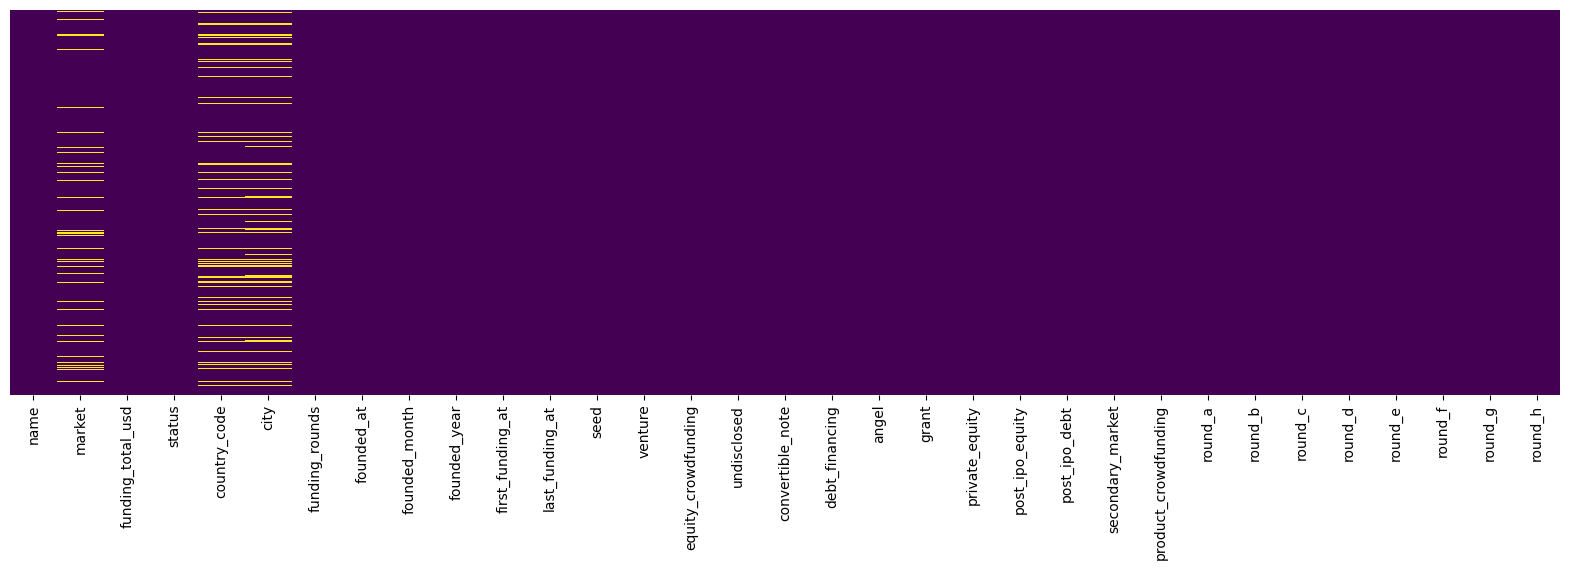

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap to visualize missing values
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
sns.heatmap(df.isna(), yticklabels=False, cbar=False, cmap='viridis')

# Show the plot
plt.show()

In [22]:
# List of columns that contribute to `funding_total_usd`
funding_columns = [
    'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'debt_financing', 'angel',
    'grant', 'private_equity', 'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding',
    'round_a', 'round_b', 'round_c', 'round_d', 'round_e', 'round_f', 'round_g', 'round_h'
]

# Check if the sum of these columns is 0 for rows where `funding_total_usd` is missing
missing_funding = df['funding_total_usd'].isna()

# Calculate the sum of the funding columns
df['funding_sum'] = df[funding_columns].sum(axis=1)

# Set `funding_total_usd` to 0 if the sum is 0 and `funding_total_usd` is missing
df.loc[missing_funding & (df['funding_sum'] == 0), 'funding_total_usd'] = 0

# Drop the auxiliary 'funding_sum' column after imputation
df.drop(columns=['funding_sum'], inplace=True)

# Save the updated dataset
df.to_csv('imputed_dataset.csv', index=False)

# Display the first few rows to verify the changes
df[['funding_total_usd']].head()


,funding_total_usd
0,1750000.0
1,4000000.0
2,40000.0
3,1500000.0
4,60000.0


In [24]:
# Drop the specified columns from the dataset
df.drop(columns=['category_list', 'founded_quarter'], inplace=True)

# Save the updated dataset
df.to_csv('imputed_dataset.csv', index=False)

# Display the first few rows to verify the changes
df.head()


,name,market,funding_total_usd,status,country_code,city,funding_rounds,founded_at,founded_month,founded_year,...,secondary_market,product_crowdfunding,round_a,round_b,round_c,round_d,round_e,round_f,round_g,round_h
0,waywire,News,1750000.0,acquired,USA,New York,1.0,2012-06-01,6,2012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,&TV Communications,Games,4000000.0,operating,USA,Los Angeles,2.0,2007-04-24,3,2007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,'Rock' Your Paper,Publishing,40000.0,operating,EST,Tallinn,1.0,2012-10-26,10,2012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,(In)Touch Network,Electronics,1500000.0,operating,GBR,London,1.0,2011-04-01,4,2011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-R- Ranch and Mine,Tourism,60000.0,operating,USA,Fort Worth,2.0,2014-01-01,1,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
